# GAN(Generative Adversarial Network)
- 생성 모델(Generator Model)의 한 종류
- 두 개의 신경망(생성자-Generator,  판별자-Discriminator)이 경쟁하며 학습하는 구조
- 두 개의 신경망이 적대적(Adversarial Training)을 수행함으로써 고품질의 데이터를 생성하는 특징
- 사례: 위조지폐 검증 부분

## GAN 모델 필요성
- 데이터 생성 및 증강: 실제 데이터를 확보하기 힘든 상황에서 GAN을 활용하여 현실적인 가상 의료 이미지를 생성할 . 있음
- 현실적인 데이터 생성: GAN을 이용하면 기존 데이터와 유사하지만 새로운 데이터를 생성할 수 있어, 게임, 영화, 광고 등의 콘텐츠 제작에 활용 가능
- 데이터 부족 문제 해결: 특정 상황에서 얻기 어려운 데이터를 GAN을 통해 생성하여 모델 학습 성능을 향상 시킬 수 있음


In [3]:
# 실행 결과
# - GAN 학습을 위한 기본적인 라이브러리 삽입
# - 데이터 로딩, 변환, 신경망 구성 및 학습 결과 시각화를 위한 환경 준비
import torch
import torch.nn as nn

import numpy as np
import glob # 파일 경로 패턴 매칭을 위한 glob 모듈 임포트
import os # 운영체제 기능(파일 시스템 등)을 사용하기 위한 os 모듈 임포트

import torchvision
from torchvision import datasets # 데이터셋 로딩을 위한 datasets 모듈 임포트
import torchvision.transforms as transforms # 이미지 변환을 위한 transforms 모듈 임포트
from torchvision.utils import save_image # 이미지 저장을 위한 save_image 함수 임포트
from torch.autograd import Variable # 자동 미분을 위한 Variable 임포트
import matplotlib.pyplot as plt # 이미지 시각화를 위한 matplotlib.pyplot 임포트
from IPython.display import Image # 주피터 노트북에 이미지 표시를 위한 Image 클래스 임포트
from IPython.display import display # 주피터 노트북에 객체 표시를 위한 display 함수 임포트

In [6]:
# 실행 결과
# - MNIST 데이터셋을 다운로드
# - MNIST 데이터셋을 전처리 한 후, 배치 단위로 불러오는 과정

batch_size = 64 # 학습에 사용할 배치 크기 설정
transforms_train = transforms.Compose([
    transforms.Resize(28), # 이미지 크기를 28x28로 조정
    transforms.ToTensor(), # 이미지를 PyTorch 텐서로 변환 (픽셀 값 [0, 1]로 정규화)
    transforms.Normalize([0.5], [0.5]) # 이미지를 평균 0.5, 표준편차 0.5로 정규화 (픽셀 값 [-1, 1] 범위로)
])
train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train) # MNIST 학습 데이터셋 로드 및 전처리 적용

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4) # 데이터 로더 생성 (배치 단위 로딩, 데이터 섞기, 멀티 프로세스 사용)

[tensor(6), tensor(9), tensor(7), tensor(1), tensor(2), tensor(7), tensor(0), tensor(0), tensor(1), tensor(7), tensor(1), tensor(9), tensor(1), tensor(4), tensor(3), tensor(7), tensor(1), tensor(0), tensor(0), tensor(0), tensor(9), tensor(8), tensor(9), tensor(6), tensor(5), tensor(1), tensor(8), tensor(2), tensor(4), tensor(8), tensor(7), tensor(1), tensor(1), tensor(6), tensor(9), tensor(2), tensor(1), tensor(4), tensor(1), tensor(3), tensor(3), tensor(2), tensor(1), tensor(8), tensor(1), tensor(3), tensor(3), tensor(8), tensor(5), tensor(9), tensor(8), tensor(6), tensor(8), tensor(1), tensor(5), tensor(7), tensor(3), tensor(1), tensor(3), tensor(3), tensor(1), tensor(2), tensor(9), tensor(9)]


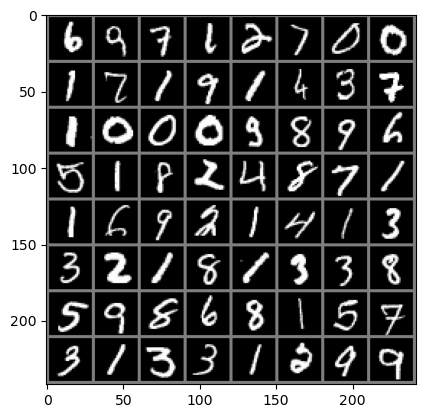

In [7]:
images, labels = next(iter(dataloader)) # 데이터 로더에서 첫 번째 이미지 배치와 레이블 가져오기
img = torchvision.utils.make_grid(images) # 이미지 배치를 그리드 형태로 합치기

img = img.numpy().transpose(1,2,0) # PyTorch 텐서를 NumPy 배열로 변환하고 차원 순서 변경 (Matplotlib용)
std = [0.5, 0.5, 0.5] # 이미지 정규화에 사용된 표준편차 (시각화를 위한 역정규화에 사용)
mean = [0.5, 0.5, 0.5] # 이미지 정규화에 사용된 평균 (시각화를 위한 역정규화에 사용)
img = img*std+mean # 이미지 역정규화 (픽셀 값을 [0, 1] 범위로 되돌림)
print([labels[i] for i in range(batch_size)]) # 첫 번째 배치에 포함된 이미지들의 레이블 출력
plt.imshow(img) # 이미지 그리드 시각화

In [8]:
# image 관련 설정
channels = 1 # 이미지 채널 수 (MNIST는 흑백이므로 1)
img_size = 28 # 이미지 크기 (높이 및 너비)
img_shape = (channels, img_size, img_size) # 이미지 형태 (튜플)

In [9]:
# 실행결과
# - Generator(생성자) 모델 정의
# - Random noise 받아 점차 해상도를 증가시키며 가짜 이미지를 생성

class Generator(nn.Module): # 생성자 모델 클래스 정의 (nn.Module 상속)
    def __init__(self): # 생성자 초기화 함수
        super(Generator, self).__init__() # 부모 클래스 초기화

        def block(input_dim, output_dim, normalize=True): # 생성자 내부에서 사용할 선형 블록 정의 함수
            layers = [nn.Linear(input_dim, output_dim)] # 입력 차원에서 출력 차원으로 변환하는 선형 레이어
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim, 0.8)) # 배치 정규화 (선택 사항)
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # LeakyReLU 활성화 함수
            return layers

        self.model = nn.Sequential( # 여러 레이어를 순차적으로 연결하는 Sequential 모델
            *block(latent_dim, output_dim=128, normalize=False), # 잠재 공간 차원에서 128로 변환하는 첫 번째 블록 (정규화 없음)
            *block(128, 256), # 128에서 256으로 변환하는 블록
            *block(256, 512), # 256에서 512로 변환하는 블록
            *block(512, 1024), # 512에서 1024로 변환하는 블록
            nn.Linear(1024, int(np.prod(img_shape))), # 1024에서 이미지 픽셀 수로 변환하는 선형 레이어
            nn.Tanh() # 출력 값을 [-1, 1] 범위로 스케일링하는 Tanh 활성화 함수
        )
    def forward(self, z): # 생성자 순전파 함수
        # z : 입력 노이즈 벡터
        img = self.model(z) # 노이즈 벡터를 모델에 통과시켜 이미지 생성
        img = img.view(img.size(0), *img_shape) # 생성된 이미지를 원래 이미지 형태(배치 크기, 채널, 높이, 너비)로 reshape
        return img # 생성된 이미지 반환

In [10]:
# 실행 결과
# Discriminator(판별자) 모델 정의
# 생성된 이미지가 진짜인지 가짜인지 판별
class Discriminator(nn.Module): # 판별자 모델 클래스 정의 (nn.Module 상속)
    def __init__(self): # 판별자 초기화 함수
        super(Discriminator, self).__init__() # 부모 클래스 초기화

        self.model = nn.Sequential( # 여러 레이어를 순차적으로 연결하는 Sequential 모델
            nn.Linear(int(np.prod(img_shape)), 512), # 이미지 픽셀 수를 입력받아 512로 변환하는 선형 레이어
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU 활성화 함수
            nn.Linear(512, 256), # 512에서 256으로 변환하는 선형 레이어
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU 활성화 함수
            nn.Linear(256, 1), # 256에서 1로 변환하는 선형 레이어 (진짜/가짜 확률 출력)
            nn.Sigmoid(), # 출력 값을 [0, 1] 범위의 확률로 변환하는 Sigmoid 활성화 함수
        )

    def forward(self, img): # 판별자 순전파 함수
        img_flat = img.view(img.size(0), -1) # 이미지를 1차원 벡터로 펼치기 (배치 크기, 모든 픽셀)
        validity = self.model(img_flat) # 펼쳐진 이미지를 모델에 통과시켜 진짜일 확률 예측

        return validity # 이미지의 진짜일 확률 반환

In [11]:
# 실행결과
# - GAN 핛습을 위한 하이퍼파라미터 설정 및 최적화 기법 정의

lr = 0.0002 # 학습률(Learning Rate) 설정

b1 = 0.5 # Adam 옵티마이저의 베타1(beta1) 파라미터 설정
b2 = 0.999 # Adam 옵티마이저의 베타2(beta2) 파라미터 설정

latent_dim = 100 # 생성자 입력으로 사용될 잠재 공간(latent space)의 차원 설정

generator = Generator() # 생성자 모델 인스턴스 생성
discriminator = Discriminator() # 판별자 모델 인스턴스 생성

adversarial_loss = nn.BCELoss() # 적대적 손실 함수로 Binary Cross-Entropy Loss 사용

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2)) # 생성자 학습을 위한 Adam 옵티마이저 설정
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2)) # 판별자 학습을 위한 Adam 옵티마이저 설정

In [12]:
# 실행결과
# - GPU가 있을 경우 GPU에서 실행할지 여부 결정

cuda = True if torch.cuda.is_available() else False # CUDA 사용 가능 여부 확인

if cuda : # CUDA 사용 가능 시 모델과 손실 함수를 GPU로 이동
  generator.cuda()
  discriminator.cuda()
  adversarial_loss.cuda()

In [13]:
# 실행결과
# - GAN 학습을 위한 기본적인 설정 정의

import time # 시간 측정을 위한 time 모듈 임포트

n_epochs = 20 # 초기 에포크 수 설정 (이후 셀에서 200으로 변경됨)

sample_interval = 2000 # 생성된 이미지를 저장할 반복(iteration) 간격 설정
start_time = time.time() # 학습 시작 시간 기록
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor # CUDA 사용 시 GPU 텐서, 아니면 CPU 텐서 사용

Showing initial generated images (before training):


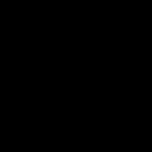

--------------------------------------------------
[Epoch 0/200] [D loss: 0.362058] [G loss: 0.944064] [Elapsed time: 892.69s]
[Epoch 1/200] [D loss: 0.363282] [G loss: 1.086486] [Elapsed time: 1070.65s]
[Epoch 2/200] [D loss: 0.641325] [G loss: 4.147587] [Elapsed time: 1248.38s]


In [ ]:
# 실행결과
# - GAN 학습 loop에서 Generator를 학습하는 과정
# - 랜덤 노이즈를 생성하고, 이를 입력으로 가짜 이미지를 생성
# - Discriminator에게 가짜 이미지를 평가하려고함
# - 가짜 이미지를 판별자가 진짜라고 착각하도록 손실 계산
# - 손실을 기반으로 생성자의 가중치 업데이트
n_epochs = 200 # 총 학습 에포크 수를 200으로 설정

# 학습 시작 전에 초기 생성 이미지 (epoch 0) 출력
print("Showing initial generated images (before training):")
z = Variable(Tensor(25, latent_dim)) # 25개의 이미지를 생성하기 위한 잠재 공간 노이즈 벡터 생성
if cuda:
    z = z.cuda() # CUDA 사용 시 노이즈 벡터를 GPU로 이동
generated_imgs = generator(z) # 생성자 모델을 사용하여 이미지 생성
save_image(generated_imgs.data[:25], "generated_epoch_0_initial.png", nrow=5, normalize=True) # 생성된 이미지 25개를 파일로 저장 (5x5 그리드, 정규화하여 저장)
display(Image(filename="generated_epoch_0_initial.png")) # 저장된 초기 이미지 파일 출력
print("-" * 50) # 구분선 출력


for epoch in range(n_epochs): # 설정된 에포크 수만큼 반복하며 학습 진행
    for i, (imgs, _) in enumerate(dataloader): # 데이터 로더에서 이미지 배치 가져오기 (레이블은 사용하지 않음)
        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 타겟 레이블 생성
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # 진짜 이미지의 타겟 레이블 (1.0)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # 가짜 이미지의 타겟 레이블 (0.0)

        real_imgs = Variable(imgs.type(Tensor)) # 실제 이미지 데이터를 현재 사용 중인 텐서 타입(CPU/GPU)으로 변환

        # ---------------------
        #  생성자(Generator) 학습
        # ---------------------

        optimizer_G.zero_grad() # 생성자 옵티마이저의 기울기 초기화

        # 생성자 입력을 위한 무작위 노이즈 벡터 생성
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        if cuda:
            z = z.cuda() # CUDA 사용 시 노이즈 벡터를 GPU로 이동

        generated_imgs = generator(z) # 생성자로 가짜 이미지 생성

        # 생성자가 생성한 가짜 이미지가 판별자에게 진짜(1.0)로 인식되도록 손실 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        g_loss.backward() # 생성자 손실에 대한 역전파 (생성자의 가중치 업데이트)
        optimizer_G.step() # 생성자 옵티마이저 스텝 (가중치 업데이트 적용)

        # ---------------------
        #  판별자(Discriminator) 학습
        # ---------------------

        optimizer_D.zero_grad() # 판별자 옵티마이저의 기울기 초기화

        # 판별자가 진짜 이미지를 진짜(1.0)로 인식하도록 손실 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        # 판별자가 생성자가 생성한 가짜 이미지를 가짜(0.0)로 인식하도록 손실 계산
        # .detach()를 사용하여 생성자 쪽으로는 기울기가 전달되지 않도록 함
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        # 판별자 손실은 진짜와 가짜 이미지에 대한 손실의 평균
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward() # 판별자 손실에 대한 역전파 (판별자의 가중치 업데이트)
        optimizer_D.step() # 판별자 옵티마이저 스텝 (가중치 업데이트 적용)

        # 생성된 이미지를 주기적으로 저장
        done = epoch * len(dataloader) + i # 현재까지 완료된 총 반복(iteration) 수 계산
        if done % sample_interval == 0: # 설정된 저장 간격마다 이미지 저장
            save_image(generated_imgs.data[:25], f"generated_epoch_{epoch}_iter_{i}.png", nrow=5, normalize=True) # 생성된 이미지 25개를 파일로 저장

    # 각 에포크 종료 시 손실 값과 소요 시간 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

    # 5 에포크마다 가장 최근에 생성된 이미지 출력
    if (epoch + 1) % 5 == 0: # 현재 에포크 번호가 5로 나누어 떨어지면 (5, 10, 15...)
        # 해당 에포크에서 저장된 가장 최근 이미지 파일 찾기
        latest_image_path = None
        # 에포크의 마지막 반복에서 저장된 이미지가 '가장 최근'이라고 가정하고 파일 경로 생성
        latest_image_path = f"generated_epoch_{epoch}_iter_{len(dataloader)-1}.png"
        # sample_interval 때문에 마지막 반복에서 이미지가 저장되지 않았을 경우를 대비한 대체 로직
        if not os.path.exists(latest_image_path):
             # 해당 에포크에서 저장된 모든 이미지 파일을 찾아 시간 순으로 정렬
             image_paths = sorted(glob.glob(f"generated_epoch_{epoch}_*.png"))
             if image_paths:
                 latest_image_path = image_paths[-1] # 가장 마지막 파일 선택

        # 가장 최근 이미지 파일이 존재하면 출력
        if latest_image_path and os.path.exists(latest_image_path):
            print(f"\nShowing generated images after Epoch {epoch+1}:") # 출력 메시지
            display(Image(filename=latest_image_path)) # 이미지 파일 출력